In [2]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
set_matplotlib_formats("svg")
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
from IPython.display import display, IFrame

def show_confidence_interval_slides():
    src="https://docs.google.com/presentation/d/e/2PACX-1vTaPZsueXI6fey_5cj2Y1TevkR1joBvpwaWVsZNvgBlnJSrw1EiBLHJywkFH_QNLU5Tdr6JZgDrhFxG/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 989
    display(IFrame(src, width, height))

# Lecture 20 – Confidence Intervals, Center and Spread

## DSC 10, Fall 2022

### Announcements

- Friday is a holiday 🎖️, so there is no lecture. Check [the calendar](https://dsc10.com/calendar/) for the latest office hours schedule. 
- Lab 6 is due **Saturday 11/12 at 11:59pm**.
- Homework 5 is due **Tuesday 11/15 at 11:59pm**.
- We'll be releasing the Final Project later today.
    - Get a partner lined up! You don't have to work with your partner from the Midterm Project.
    - The [rules](https://dsc10.com/pair-programming/) for working with a partner have changed.
- Come hang out with your instructors:
    - Tonight from 5-6pm in CSE 4140, come watch Suraj participate in "Professor Talks: Spicy Challenge 🌶" with faculty from CSE. See more details [here](https://twitter.com/niemasd/status/1588658101787717632?s=20&t=4FRjNgZl8d_-ZHua8SLpnQ).
    - On Tuesday 11/15 from 10-11am in the SDSC Auditorium, come talk to Janine, Suraj, and other HDSI faculty at the HDSI faculty/student mixer!

### Agenda

- Interpreting confidence intervals.
- Confidence intervals for hypothesis testing.
- Mean and median.
- Standard deviation.

## Interpreting confidence intervals

### Recap: City of San Diego employee salaries

Let's rerun our code from last time to compute a 95% confidence interval for the median salary of all San Diego city employees, based on a sample of 500 people.

**Step 1:** Collect a single sample of size 500 from the population.

In [3]:
np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.

population = bpd.read_csv('data/2021_salaries.csv').get(['TotalWages'])
population_median = population.get('TotalWages').median()

my_sample = population.sample(500)
sample_median = my_sample.get('TotalWages').median()
sample_median

72016.0

**Step 2:** Bootstrap! That is, resample from the sample a large number of times, and each time, compute the median of the resample. This will generate an empirical distribution of the sample median.

In [4]:
np.random.seed(38)

# Bootstrap the sample to get more sample medians.
n_resamples = 5000
boot_medians = np.array([])

for i in np.arange(n_resamples):
    resample = my_sample.sample(500, replace=True)
    median = resample.get('TotalWages').median()
    boot_medians = np.append(boot_medians, median)
    
boot_medians

array([74261. , 73080. , 72486. , ..., 68216. , 76159. , 69768.5])

**Step 3:** Take the middle 95% of the empirical distribution of sample medians (i.e. `boot_medians`). This creates our 95% confidence interval.

In [5]:
left = np.percentile(boot_medians, 2.5)
right = np.percentile(boot_medians, 97.5)

# Therefore, our interval is:
[left, right]

[66987.0, 76527.0]

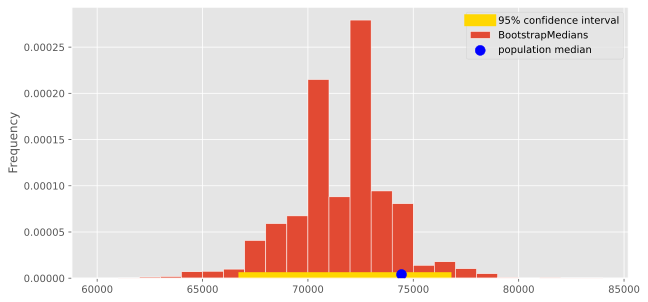

In [6]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval');
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median').set_zorder(3)
plt.legend();

### Confidence intervals describe a guess for the value of an unknown parameter

Now, instead of saying

> We think the population median is close to our sample median, \\$72,016.

We can say:

> A 95% confidence interval for the population median is \\$66,987 to \\$76,527.

**Today, we'll address**: What does 95% confidence mean? What are we confident about? Is this technique always "good"?

### Interpreting confidence intervals

- We create a confidence interval such that 95% of our bootstrap medians fell within this interval.
- We're pretty confident that the true population median does, too.
- How confident should we be about this? **What does a 95% confidence interval mean?**

### Capturing the true value

- Consider the process of:
    1. Collecting a **new original sample** from the population,
    1. Bootstrap resampling from it many times, computing the statistic (e.g. median) in each resample, and
    1. Constructing a new 95% confidence interval.

- A 95% confidence level means that **approximately 95% of the time, the intervals you create through this process will contain the true population parameter**.

- The confidence is in **the process** that generates the interval.

### Many confidence intervals

- We repeated the process outlined on the previous slide 200 times, to come up with 200 confidence intervals.
    - We did this in advance (it took a really long time) and saved the results to a file.
- The resulting CIs are stored in the array `many_cis` below.

In [8]:
many_cis = np.load('data/many_cis.npy')
many_cis

array([[70247.  , 80075.68],
       [63787.65, 75957.5 ],
       [71493.  , 82207.5 ],
       ...,
       [66679.64, 81308.  ],
       [65735.68, 80060.21],
       [69756.1 , 80383.5 ]])

In the visualization below,
- The blue line represents the population parameter. **This is not random.**
- Each gold line represents a separate confidence interval, created using the specified process.
- Most of these confidence intervals contain the true parameter – but not all!

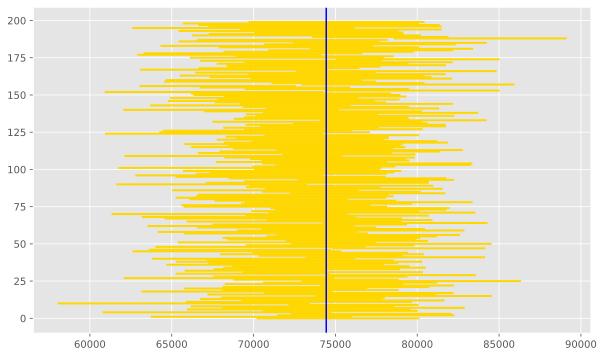

In [9]:
plt.figure(figsize=(10, 6))
for i, ci in enumerate(many_cis):
    plt.plot([ci[0], ci[1]], [i, i], color='gold', linewidth=2)
plt.axvline(x=population_median, color='blue');

### Which confidence intervals don't contain the true parameter?

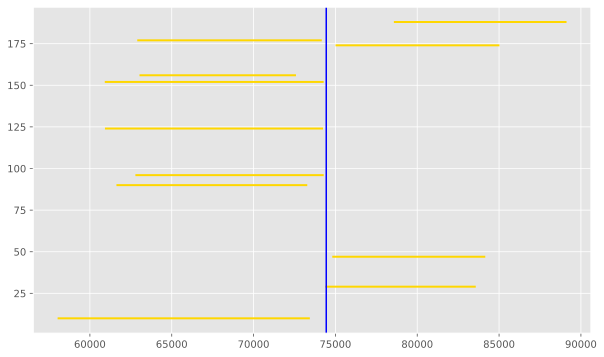

In [10]:
plt.figure(figsize=(10, 6))
count_outside = 0
for i, ci in enumerate(many_cis):
    if ci[0] > population_median or ci[1] < population_median:
        plt.plot([ci[0], ci[1]], [i, i], color='gold', linewidth=2)
        count_outside = count_outside + 1
plt.axvline(x=population_median, color='blue');

In [11]:
count_outside

11

- 11 of our 200 confidence intervals didn't contain the true parameter.
- That means 189/200, or 94.5% of them, did.
    - This is pretty close to 95%!

- In reality, you will have **only one confidence interval, and no way of knowing if it contains the true parameter**, since you have no way of knowing if your one original sample is good.

### Confidence tradeoffs

- When we use an "unlucky" sample to make our CI, the CI won't contain the population parameter.

- If we choose a 99% confidence level, 
    - only about 1% of our samples will be "unlucky", but
    - our intervals will be very wide and thus not that useful.

- If we choose an 80% confidence level, 
    - more of our samples will be "unlucky", but
    - our intervals will be narrower and thus more precise.

- At a fixed confidence level, how do we decrease the width of a confidence interval?
    - By taking a bigger sample!
    - We'll soon see how sample sizes, confidence levels, and CI widths are related to one another.

### Misinterpreting confidence intervals

Confidence intervals can be hard to interpret.

In [12]:
# Our interval:
[left, right]

[66987.0, 76527.0]

**Does this interval contain 95% of all salaries? No!** ❌

However, this interval does contain 95% of all bootstrapped median salaries. 

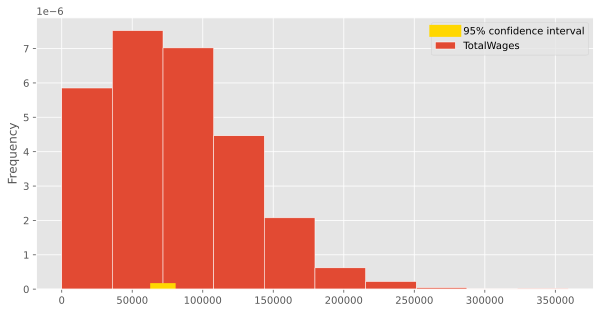

In [13]:
population.plot(kind='hist', y='TotalWages', density=True, ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval');
plt.legend();

In [14]:
# Our interval:
[left, right]

[66987.0, 76527.0]

**Is there is a 95% chance that this interval contains the population parameter? No!** ❌

Why not?
- The population parameter is fixed. In reality, we might not know it, but it is **not random**.
- The interval above is not random, either (but the process that creates it is).
- For a given interval, the population parameter is in the interval, or it is not. There is no randomness involved.
- Remember that the 95% confidence is in the process that created an interval.
- This process (sampling, then bootstrapping, then creating an interval) creates a good interval roughly 95% of the time.

In [15]:
show_confidence_interval_slides()

### Bootstrap rules of thumb

- The bootstrap is an awesome tool! We only had to collect a single sample from the population to get the (approximate) distribution of the sample median.

- But it has limitations:
    - It is not good for sensitive statistics, like the max or min.
    - It only gives useful results if the sample is a good approximation of population.
        - If our original sample was not representative of the population, the resulting bootstrapped samples will also not be representative of the population.

### Example: Estimating the max of a population

- Suppose we want to estimate the maximum salary of all San Diego city employees, given just a single sample, `my_sample`.
- Our estimate will be the max in the sample. This is a statistic.
- To get the empirical distribution of this statistic, we bootstrap:

In [16]:
n_resamples = 5000
boot_maxes = np.array([])

for i in range(n_resamples):
    resample = my_sample.sample(my_sample.shape[0], replace=True)
    boot_max = resample.get('TotalWages').max()
    boot_maxes = np.append(boot_maxes, boot_max)

In [17]:
boot_maxes

array([235709., 329949., 247093., ..., 329949., 329949., 235709.])

### Visualize

Since we have access to the population, we can find the population maximum directly, without bootstrapping.

In [18]:
population_max = population.get('TotalWages').max()
population_max

359138

Does the population maximum lie within the bulk of the bootstrapped distribution?

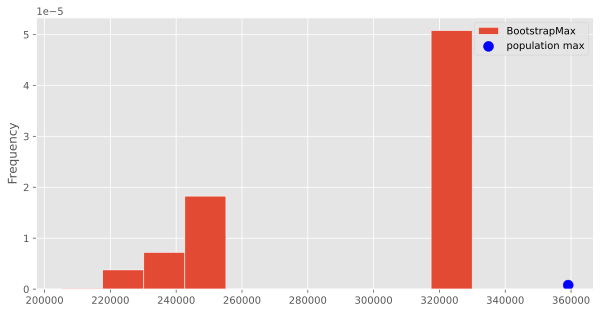

In [19]:
bpd.DataFrame().assign(BootstrapMax=boot_maxes).plot(kind='hist', 
                                                     density=True, 
                                                     bins=10,
                                                     ec='w',
                                                     figsize=(10, 5))
plt.scatter(population_max, 0.0000008, color='blue', s=100, label='population max')
plt.legend();

No, the bootstrapped distribution doesn't capture the population maximum (<span style="color:blue"><b>blue dot</b></span>) of \$359,138. Why not? 🤔

In [20]:
my_sample.get('TotalWages').max()

329949

- The largest value in our original sample was \$329,949. 
- Therefore, the largest value in any bootstrapped sample is at most \$329,949.

- Generally, the bootstrap works better for measures of central tendency or variation (means, medians, variances) than it does for extreme values (maxes and mins).

## Confidence intervals for hypothesis testing

### Using a confidence interval for hypothesis testing

It turns out that we can use bootstrapped confidence intervals for hypothesis testing!

- **Null Hypothesis**: The population parameter is equal to some value, $x$.
- **Alternative Hypothesis**: The population parameter is not equal to $x$.

- Cutoff for p-value: p%.

- Strategy:
    - Construct a (100-p)% confidence interval for the population parameter.
    - If $x$ is not in the interval, we reject the null hypothesis.
    - If $x$ is in the interval, we fail to reject the null hypothesis (since our results are consistent with the null).

### Example: Fire-Rescue Department 🚒

In [21]:
population = bpd.read_csv('data/2021_salaries.csv')
fire_rescue_population = population[population.get('DepartmentOrSubdivision') == 'Fire-Rescue']
fire_rescue_population

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,...,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
4,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
5,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
6,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
12301,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
12302,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
12304,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN


### Setting up a hypothesis test
- Suppose we only have access to a sample of 300 Fire-Rescue Department workers.
- We want to understand the median salary of *all* Fire-Rescue Department workers.



- **Null Hypothesis**: The median salary of Fire-Rescue Department workers is the same as the median salary of all San Diego city employees, \$74,441.
- **Alternative Hypothesis**: The median salary of Fire-Rescue Department workers is not the same as the median salary of all San Diego city employees.

- We'll use a significance level (i.e. p-value cutoff) of 0.01.

In [22]:
# The median salary of all City of SD employees, in all departments.
population_median = population.get('TotalWages').median()
population_median

74441.0

In [23]:
np.random.seed(38)

fire_rescue_sample = fire_rescue_population.sample(300)
fire_rescue_sample

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,...,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
6762,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
8754,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
3783,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
10812,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
11112,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
11009,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN


### Testing the hypotheses
- Since we're using a significance level of 0.01 = 1%, we need a 99% confidence interval for the median salary of Fire-Rescue Department workers.
- To construct this confidence interval, we'll bootstrap to compute many sample medians, and we'll find the middle 99% of the distribution of bootstrapped medians using `np.percentile`.

In [24]:
n_resamples = 500
fire_rescue_medians = np.array([])
for i in range(n_resamples):
    # Resample from fire_rescue_sample.
    resample = fire_rescue_sample.sample(300, replace=True)
    
    # Compute the median.
    median = resample.get('TotalWages').median()
    
    # Add it to our array of bootstrapped medians.
    fire_rescue_medians = np.append(fire_rescue_medians, median)

In [25]:
fire_rescue_medians

array([ 90959. , 100759. ,  92676. , ...,  95701.5,  94562. ,  99148. ])

### Finding the interval

In [26]:
fire_left = np.percentile(fire_rescue_medians, 0.5)
fire_left

82766.5

In [27]:
fire_right = np.percentile(fire_rescue_medians, 99.5)
fire_right

108676.585

In [28]:
# Resulting interval:
[fire_left, fire_right]

[82766.5, 108676.585]

Is \$74,441 in this interval? No. ❌

### Conclusion of the hypothesis test
- Since our 99% confidence interval did not contain the median salary of all San Diego city employees (\$74,441), we reject the null.
- Our sample suggests that Fire-Rescue Department workers do not have the same median salary as other city employees.
- We can't say why.

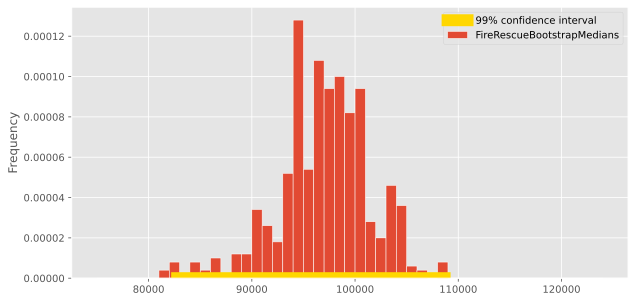

In [29]:
bpd.DataFrame().assign(FireRescueBootstrapMedians=fire_rescue_medians).plot(kind='hist', density=True, bins=np.arange(75000, 125000, 1000), ec='w', figsize=(10, 5))
plt.plot([fire_left, fire_right], [0, 0], color='gold', linewidth=12, label='99% confidence interval');
plt.legend();

In [30]:
# Actual population median of Fire-Rescue Department salaries:
fire_rescue_population.get('TotalWages').median()

97388.0

### Summary of methods

- To test whether a sample came from a known population distribution, use "standard" hypothesis testing. 

- To test whether two samples came from the same unknown population distribution, use permutation testing.

- To estimate a population parameter given a single sample, use bootstrapping to construct a confidence interval.

- To test whether a population parameter is equal to a particular value, $x$, use bootstrapping to construct a confidence interval, and check whether $x$ is in the interval.

## Mean and median

### The mean (i.e. average)

The mean is a one-number summary of a set of numbers. For example, the mean of $2, 3, 3,$ and $9$ is $\frac{2 + 3 + 3 + 9}{4} = 4.25$.

Observe that the mean:

- Doesn't have to be equal to one of the data points.



- Doesn't have to be an integer, even if all of the data points are integers.



- Is somewhere between the min and max, but not necessarily halfway between.

- Has the same units as the data.

### The median

- Like the mean, the median is a one-number summary of a set of numbers.
- To calculate it, **sort the data points and pick the number in the middle**.
    - If there are two middle numbers, we usually pick the number halfway between (i.e. the mean of the middle two).

- **Example:** $\text{Median}(1, 4, 7, 12, 32) = 7$

- **Example:** $\text{Median}(1, 4, 7, 12) = 5.5$

### Activity

Create a set of data points that has this histogram. (You can do it with a short list of whole numbers.)

<br>
<center><img src='data/hist.jpg' width=450></center>
<br>

What are its mean and median?

In [ ]:
mean = 3

In [ ]:
median = 3

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com)

<center>
    <table><tr>
        <td> <center><img src="data/hist.jpg" width=70%></center>  </td>
        <td> <center><img src="data/hist2.jpg" width=70%></center> </td>
    </tr></table>
</center>

Are the means of these two distributions the same or different? What about the medians?

- A. Both are the same
- B. Means are different, medians are same
- C. Means are same, medians are different
- D. Both are different

### Example: Flight delays ✈️

In [ ]:
delays = bpd.read_csv('data/delays.csv')
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', figsize=(10, 5))
plt.title('Flight Delays')
plt.xlabel('Delay (minutes)');

**Question:** Which is larger – the mean or the median?

In [ ]:
delays.get('Delay').mean()

In [ ]:
delays.get('Delay').median()

In [ ]:
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', alpha=0.65, figsize=(10, 5))
plt.plot([delays.get('Delay').mean(), delays.get('Delay').mean()], [0, 1], color='green', label='Mean')
plt.scatter([delays.get('Delay').mean()], [-0.0017], color='green', marker='^', s=250)
plt.plot([delays.get('Delay').median(), delays.get('Delay').median()], [0, 1], color='purple', label='Median')
plt.title('Flight Delays')
plt.xlabel('Delay (minutes)')
plt.ylim(-0.005, 0.065)
plt.legend();

### Comparing the mean and median
- **Mean:** Balance point of the histogram.
    - Numerically: the sum of the differences between all data points and the mean is 0.
    - Physically: Think of a see-saw.

- **Median:** Half-way point of the data.
    - Half of the area of a histogram is to the left of the median, and half is to the right.


- If the distribution is symmetric about a value, then that value is both the mean and the median.
- If the distribution is **skewed**, then the mean is pulled away from the median in the direction of the tail.

- **Key property:** The median is more **robust** (less **sensitive**) to **outliers**.

## Standard deviation

### Question: How "wide" is a distribution? 

- **One idea:** “biggest value - smallest value” (known as the **range**).
    - Issue: this doesn’t tell us much about the shape of the distribution.

- **Another idea:** "standard deviation".
    - The mean is at the center. 
    - The standard deviation quantifies how far the data points typically are from the center.

### Deviations from the mean

In [ ]:
data = np.array([2, 3, 3, 9])
np.mean(data)

In [ ]:
deviations = data - np.mean(data)
deviations

Each entry in `deviations` describes how far the corresponding element in `data` is from 4.25.

What is the average deviation?

In [ ]:
np.mean(deviations)

- This is true of any dataset – the average deviation from the mean is always 0.
- This implies that the average deviation itself is not useful in measuring the spread of data.

### Average **squared** deviation

In [ ]:
# Square all the deviations:
deviations ** 2

In [ ]:
variance = np.mean(deviations ** 2)
variance

This quantity, the average squared deviation from the mean, is called the **variance**.

### Standard deviation

- Our data usually has units, e.g. dollars.
- The variance is in "squared" units, e.g. $\text{dollars}^2$.
- To account for this, we can take the square root of the variance, and the result is called the **standard deviation**.

In [ ]:
# Standard deviation (SD) is the square root of the variance.
sd = variance ** 0.5
sd

### Standard deviation

- The standard deviation (SD) measures something about how far the data values are from their average.
    - It is not directly interpretable because of the squaring and square rooting.
    - But generally, **larger SD = more spread out**.

- The standard deviation has the same units as the original data.

- `numpy` has a function, `np.std`, that calculates the standard deviation for us.

In [ ]:
# Note that this evaluates to the same number we found on the previous slide.
np.std(data)

### Variance and standard deviation

To summarize:

$$\begin{align*}\text{variance} &= \text{average squared deviation from the mean}\\
&= \frac{(\text{value}_1 - \text{mean})^2 + ... + (\text{value}_n - \text{mean})^2}{n}\\
\text{standard deviation} &= \sqrt{\text{variance}}
\end{align*}$$

where $n$ is the number of observations.

### What can we do with the standard deviation?

It turns out, no matter what the shape of the distribution is, the bulk of the data are in the range “average ± a few SDs”.

More on this next class!

## Summary, next time

### Summary: Confidence intervals and hypothesis testing

- **Null Hypothesis**: The population parameter is equal to some value, $x$.
- **Alternative Hypothesis**: The population parameter is not equal to $x$.
- Cutoff for p-value: p%.
- Strategy:
    - Construct a (100-p)% confidence interval for the population parameter.
    - If $x$ is not in the interval, we reject the null hypothesis.
    - If $x$ is in the interval, we fail to reject the null hypothesis (since our results are consistent with the null).

### Summary: Center and spread

- The mean and median are both ways to quantify the "center" of a set of data points.
    - The mean is less robust to outliers than the median.
- Variance and standard deviation (SD) quantify how spread out data points are.
    - Standard deviation is the square root of variance.
    - Roughly speaking, the standard deviation describes how far values in a dataset typically are from the mean.

### Next time

- If we know the mean and standard deviation of a distribution, but nothing else, what can we say about its shape?
- What is the "normal" distribution, and how does it relate to some of the distributions we've already seen?